<a href="https://colab.research.google.com/github/mahesh-babu-chittem/Machine-Learning-MaheshBabuChittem/blob/main/Lab2_AP23110010084_FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Feature Engineering — Part A: Individual Concepts (Colab-Ready)

**Updated:** 2025-08-22

This notebook is designed for **first-time learners**. You will practice each feature engineering step **individually** (no pipelines yet), so you can clearly see *what each step does* and *why it matters*.

**What you'll practice:**
- Dataset loading & quick audit
- Handling missing values (drop, impute)
- Scaling & normalization (standardization, min-max, per-row normalization)
- Encoding categorical variables (ordinal vs one-hot)
- Feature transformations (log, power, polynomial)
- Simple dimensionality reduction (PCA) for visualization
- Short exercises after each section

> Use this Part A first. After you are comfortable, move to **Part B (Pipelines)** to automate and combine steps.

## 0) Setup

In [8]:
# If running in Google Colab, you can install optional packages here:
# !pip install -q statsmodels==0.14.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', 100)

## 1) Dataset Setup & Quick Audit

In [10]:
# Option A: Load Titanic from a stable GitHub mirror (recommended for first run)
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)
print("Shape:", df.shape)
df.head()

Shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Option B: Upload your own CSV (uncomment to use in Colab)
from google.colab import files
up = files.upload()  # pick file
import io
df = pd.read_csv(io.BytesIO(up[list(up.keys())[0]]))
print("Shape:", df.shape)
df.head()

KeyboardInterrupt: 

In [11]:
# Quick audit
print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))
print("\nNumeric describe:")
df.describe().T


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values per column:
Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 2) Handling Missing Values (Individually)

**Goal:** Learn when to **drop** vs **impute**.

**Common choices**
- Numeric: mean/median
- Categorical: most frequent

We'll practice on Titanic columns like `Age`, `Embarked`, and `Cabin`.

In [12]:
# View null counts
df.isna().sum().sort_values(ascending=False).head(10)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


In [13]:
print(df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [14]:
# 2.1 DROP example (use cautiously)
df_drop_rows = df.dropna(subset=['Age', 'Embarked'])  # drop rows where these are null
print("Original:", df.shape, "After drop:", df_drop_rows.shape)

Original: (891, 12) After drop: (712, 12)


In [17]:
# 2.2 SIMPLE IMPUTE example
df_imp = df.copy()
# Numeric (Age): median
df_imp['Age'] = df_imp['Age'].fillna(df_imp['Age'].median())
# Categorical (Embarked): most frequent
df_imp['Embarked'] = df_imp['Embarked'].fillna(df_imp['Embarked'].mode()[0])

# 'Cabin' is very sparse; we can fill with "Unknown"
df_imp['Cabin'] = df_imp['Cabin'].fillna('Unknown')

df_imp.isna().sum().head(10)

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [18]:
# 2.3 KNN Imputation (numeric only demonstration)
num_cols = df.select_dtypes(include=['number']).columns.tolist()
knn_df = df[num_cols].copy()
imputer = KNNImputer(n_neighbors=3)
knn_imputed = imputer.fit_transform(knn_df)
knn_imputed_df = pd.DataFrame(knn_imputed, columns=num_cols)
knn_imputed_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500


**📝 Exercise 2**
1) Compare **mean vs median** imputation for `Age`. Which preserves the original distribution better?  
2) For `Embarked`, try filling with a new category (`'Unknown'`) vs mode. What changes in `value_counts()`?

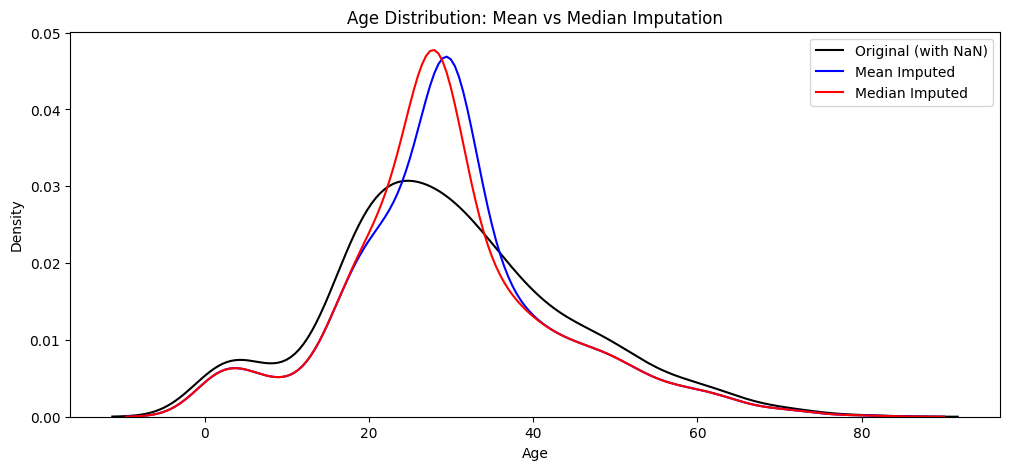

In [20]:
#Exercise 2) 1)
import seaborn as sns
import matplotlib.pyplot as plt

# Copy datasets for fair comparison
df_mean = df.copy()
df_median = df.copy()

# Imputation
# Mean imputation
df_mean['Age'] = df_mean['Age'].fillna(df_mean['Age'].mean())

# Median imputation
df_median['Age'] = df_median['Age'].fillna(df_median['Age'].median())


# Compare distributions
plt.figure(figsize=(12,5))

sns.kdeplot(df['Age'], label='Original (with NaN)', color='black')
sns.kdeplot(df_mean['Age'], label='Mean Imputed', color='blue')
sns.kdeplot(df_median['Age'], label='Median Imputed', color='red')

plt.legend()
plt.title("Age Distribution: Mean vs Median Imputation")
plt.show()


In [22]:
# Copy datasets
df_mode = df.copy()
df_unknown = df.copy()

# Mode imputation
df_mode['Embarked'] = df_mode['Embarked'].fillna(df_mode['Embarked'].mode()[0])

# New category imputation
df_unknown['Embarked'] = df_unknown['Embarked'].fillna('Unknown')

# Compare value counts
print("Original:\n", df['Embarked'].value_counts(dropna=False))
print("\nMode filled:\n", df_mode['Embarked'].value_counts())
print("\nUnknown filled:\n", df_unknown['Embarked'].value_counts())


Original:
 Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

Mode filled:
 Embarked
S    646
C    168
Q     77
Name: count, dtype: int64

Unknown filled:
 Embarked
S          644
C          168
Q           77
Unknown      2
Name: count, dtype: int64


## 3) Scaling & Normalization (Individually)

- **Standardization**: z = (x - mean)/std (good for many ML models)
- **MinMax scaling**: maps to [0,1] (useful when features have different units)
- **Per-row Normalization**: scales each *row vector* to unit norm (useful for text-like frequency vectors)

We'll demonstrate on `Fare` and `Age`.

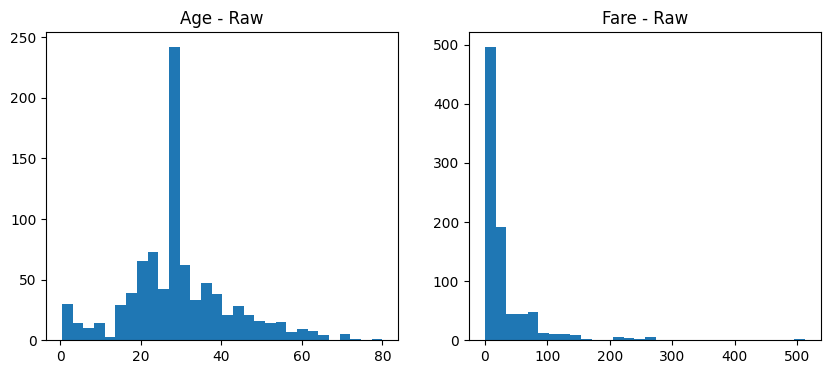

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df_imp['Age'].dropna(), bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(df_imp['Fare'].dropna(), bins=30)
axes[1].set_title('Fare - Raw')
plt.show()

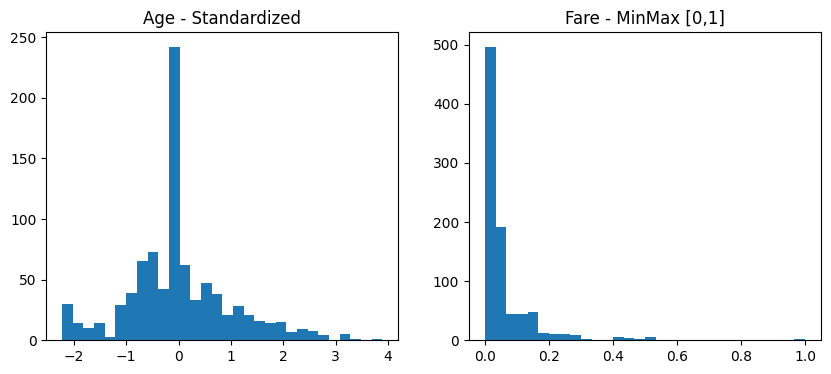

In [24]:
sc_std = StandardScaler()
sc_mm  = MinMaxScaler()

age_std = sc_std.fit_transform(df_imp[['Age']])
fare_mm = sc_mm.fit_transform(df_imp[['Fare']])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(age_std.flatten(), bins=30)
axes[0].set_title('Age - Standardized')
axes[1].hist(fare_mm.flatten(), bins=30)
axes[1].set_title('Fare - MinMax [0,1]')
plt.show()

**📝 Exercise 3**
1) Standardize `Fare` and plot the histogram.  
2) Apply **Normalizer** on `[Age, Fare]` rows and check the first 5 normalized vectors.

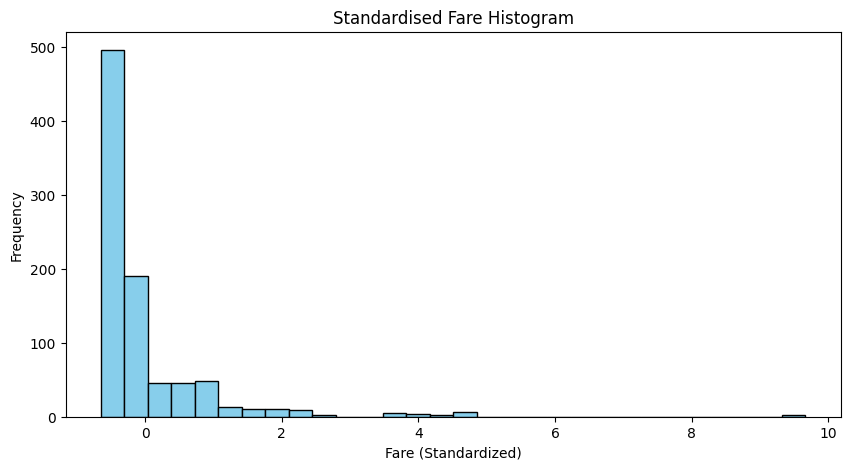

In [28]:
#Exercise 3) 1) Standardise Fare and plot the histogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Copy dataset
df_std = df.copy()

# Standardize Fare
scaler = StandardScaler()
df_std['Fare_std'] = scaler.fit_transform(df_std[['Fare']])

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(df_std['Fare_std'], bins=30, color='skyblue', edgecolor='black')
plt.title("Standardised Fare Histogram")
plt.xlabel("Fare (Standardized)")
plt.ylabel("Frequency")
plt.show()

In [29]:
#Exercise 3) 2) Apply Normaliser on [Age, Fare] rows and check the first 5 normalised vectors.
from sklearn.preprocessing import Normalizer

# Select columns
X = df[['Age', 'Fare']].fillna(df[['Age', 'Fare']].median())  # fill NaNs first

# Initialize normaliser (scales each row vector to unit norm)
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X)

# Convert to DataFrame for better viewing
import pandas as pd
X_norm_df = pd.DataFrame(X_normalized, columns=['Age_norm', 'Fare_norm'])

# Show first 5 normalised vectors
X_norm_df.head()


,Age_norm,Fare_norm
0,0.949757,0.312988
1,0.470417,0.882444
2,0.956551,0.291564
3,0.550338,0.834942
4,0.974555,0.224148


## 4) Encoding Categorical Variables (Individually)

- **Ordinal/Label encoding**: map categories to integers (assumes order or used with tree models).  
- **One-Hot encoding**: binary column per category (no order assumption).

We'll use `Sex` and `Embarked` as examples.

In [30]:
# 4.1 Ordinal encoding demo (note: no real order in Sex/Embarked; this is just to illustrate)
enc = OrdinalEncoder()
ord_demo = df_imp[['Sex','Embarked']].copy()
ord_vals = enc.fit_transform(ord_demo)
pd.DataFrame(ord_vals, columns=['Sex_ord','Embarked_ord']).head()

,Sex_ord,Embarked_ord
0,1.0,2.0
1,0.0,0.0
2,0.0,2.0
3,0.0,2.0
4,1.0,2.0


In [31]:
# 4.2 One-Hot encoding demo with pandas
ohe_embarked = pd.get_dummies(df_imp['Embarked'], prefix='Embarked')
ohe_sex = pd.get_dummies(df_imp['Sex'], prefix='Sex')
encoded_df = pd.concat([df_imp[['Survived','Age','Fare']], ohe_sex, ohe_embarked], axis=1)
encoded_df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,7.2500,False,True,False,False,True
1,1,38.0,71.2833,True,False,True,False,False
2,1,26.0,7.9250,True,False,False,False,True
3,1,35.0,53.1000,True,False,False,False,True
4,0,35.0,8.0500,False,True,False,False,True


**📝 Exercise 4**
1) Compare the **number of features** produced by ordinal vs one-hot for `Embarked`.  
2) Why might one-hot be safer for linear models?

In [34]:
# Exercise 4) 1) Compare number of features produced by ordinal vs one-hot for Embarked
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

df_enc = df.copy()  # copy dataset
df_enc['Embarked'] = df_enc['Embarked'].fillna('S')  # fill missing Embarked values

# Ordinal Encoding
ord_enc = OrdinalEncoder()
embarked_ord = ord_enc.fit_transform(df_enc[['Embarked']])
print(embarked_ord[:10])  # show first 10 rows for ordinal encoding
print("Number of features (Ordinal):", embarked_ord.shape[1])  # number of ordinal features

# One-Hot Encoding (use sparse_output=False in recent sklearn versions)
ohe = OneHotEncoder(sparse_output=False)
embarked_ohe = ohe.fit_transform(df_enc[['Embarked']])
print(embarked_ohe[:10])  # show first 10 rows for one-hot encoding
print("Number of features (One-Hot):", embarked_ohe.shape[1])  # number of one-hot features

# Exercise 4) 2) Why one-hot might be safer for linear models
# One-hot avoids implying order among categories, making it safer for linear models.

[[2.]
 [0.]
 [2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [2.]
 [2.]
 [0.]]
Number of features (Ordinal): 1
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
Number of features (One-Hot): 3


## 5) Feature Transformation (Individually)

- **Log transform**: t = log1p(x) for right-skewed positive data (e.g., Fare).
- **Power transform**: Yeo-Johnson can handle zero/negative values; stabilizes variance.
- **Polynomial features**: create interactions/quadratics for simple non-linear modeling.

We'll use `Fare` and `Age`.

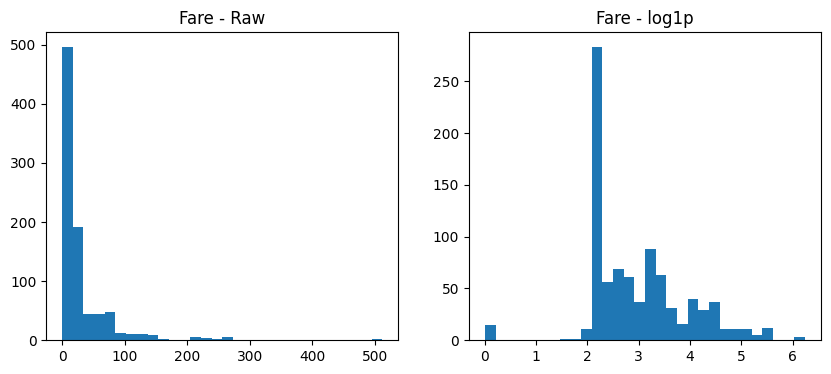

In [35]:
# 5.1 Log transform on Fare (positive values)
fare_raw = df_imp['Fare'].dropna().values.reshape(-1,1)
fare_log = np.log1p(fare_raw)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(fare_raw.flatten(), bins=30)
axes[0].set_title('Fare - Raw')
axes[1].hist(fare_log.flatten(), bins=30)
axes[1].set_title('Fare - log1p')
plt.show()

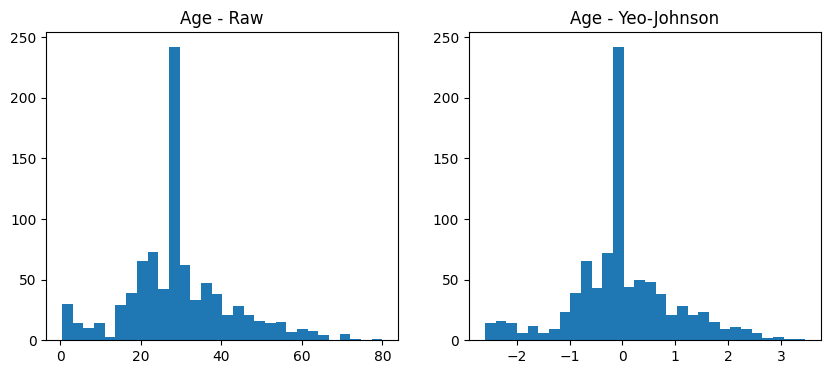

In [36]:
# 5.2 Power transform (Yeo-Johnson) on [Age, Fare]
pt = PowerTransformer(method='yeo-johnson')
af = df_imp[['Age','Fare']].dropna()
af_pt = pt.fit_transform(af)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(af['Age'].values, bins=30)
axes[0].set_title('Age - Raw')
axes[1].hist(af_pt[:,0], bins=30)
axes[1].set_title('Age - Yeo-Johnson')
plt.show()

In [37]:
# 5.3 Polynomial features on [Age, Fare] (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
af_poly = poly.fit_transform(af[['Age','Fare']])
print("Original shape:", af[['Age','Fare']].shape, " -> With poly:", af_poly.shape)
poly.get_feature_names_out(['Age','Fare'])[:6]

Original shape: (891, 2)  -> With poly: (891, 5)


array(['Age', 'Fare', 'Age^2', 'Age Fare', 'Fare^2'], dtype=object)

**📝 Exercise 5**
1) Identify one numeric column that is **skewed**. Try both **log** and **power** transforms and compare histograms.  
2) With `PolynomialFeatures(2)`, which new terms are created from `Age` and `Fare`?

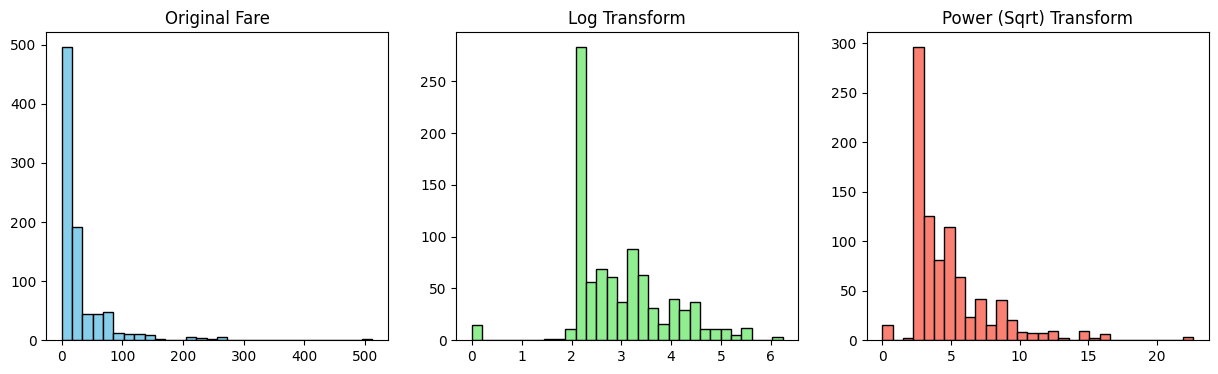

In [39]:
#Exercise - 5) 1) Skewed numeric column → log and power transforms

import numpy as np
import matplotlib.pyplot as plt

# Copy dataset
df_num = df.copy()

# Fill missing Age for safe transformation
df_num['Age'] = df_num['Age'].fillna(df_num['Age'].median())

# Skewed numeric column: Fare
skew_col = 'Fare'

# Log transform (add 1 to avoid log(0))
df_num['Fare_log'] = np.log1p(df_num[skew_col])

# Power transform (square root)
df_num['Fare_sqrt'] = np.sqrt(df_num[skew_col])

# Compare histograms
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(df_num[skew_col], bins=30, color='skyblue', edgecolor='black')
plt.title('Original Fare')

plt.subplot(1,3,2)
plt.hist(df_num['Fare_log'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Log Transform')

plt.subplot(1,3,3)
plt.hist(df_num['Fare_sqrt'], bins=30, color='salmon', edgecolor='black')
plt.title('Power (Sqrt) Transform')

plt.show()

In [41]:
#Exercise 5) 2) PolynomialFeatures(2) from Age and Fare
from sklearn.preprocessing import PolynomialFeatures

# Select columns
X = df_num[['Age', 'Fare']]

# Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Convert to DataFrame for clarity
poly_cols = poly.get_feature_names_out(['Age', 'Fare'])
X_poly_df = pd.DataFrame(X_poly, columns=poly_cols)

# Show first 5 rows
X_poly_df.head()

,Age,Fare,Age^2,Age Fare,Fare^2
0,22.0,7.2500,484.0,159.5000,52.562500
1,38.0,71.2833,1444.0,2708.7654,5081.308859
2,26.0,7.9250,676.0,206.0500,62.805625
3,35.0,53.1000,1225.0,1858.5000,2819.610000
4,35.0,8.0500,1225.0,281.7500,64.802500


## 6) Simple Dimensionality Reduction (PCA) — Visualization Only

We will apply PCA to **numeric** features to reduce to 2D and make a scatter plot colored by `Survived` (if present).

> Note: This is for **intuition/visualization** only in Part A.

Explained variance ratios: [0.96165195 0.03587775]


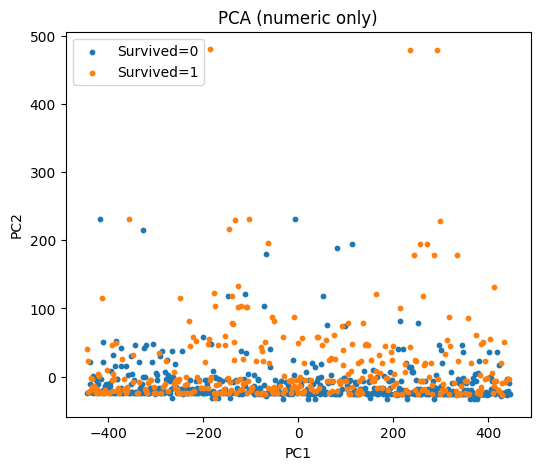

In [42]:
# Prepare a numeric-only frame (drop NA for simplicity here)
num_only = df_imp.select_dtypes(include=['number']).dropna()
y = df_imp.loc[num_only.index, 'Survived'] if 'Survived' in df_imp.columns else None

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(num_only.values)

print("Explained variance ratios:", pca.explained_variance_ratio_)

# Plot
plt.figure(figsize=(6,5))
if y is not None:
    # Color by Survived (0/1). Using a simple split to avoid specifying colors.
    idx0 = (y.values == 0)
    idx1 = (y.values == 1)
    plt.scatter(Z[idx0,0], Z[idx0,1], s=10, label='Survived=0')
    plt.scatter(Z[idx1,0], Z[idx1,1], s=10, label='Survived=1')
    plt.legend()
else:
    plt.scatter(Z[:,0], Z[:,1], s=10)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (numeric only)')
plt.show()

**📝 Exercise 6**
1) Which **two numeric columns** contribute the most variance before PCA (use `df.var()`)?  
2) Try PCA with `n_components=3` and print the cumulative explained variance.

In [43]:
#Exercise 6) 1) Which two numeric columns contribute the most variance before PCA (use df.var())?

import pandas as pd

# Select numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df_num = df[numeric_cols].copy()

# Fill missing Age for safe calculations
df_num['Age'] = df_num['Age'].fillna(df_num['Age'].median())

# Compute variance
variance = df_num.var()
print("Variance of numeric columns:\n", variance)

# Identify top 2 columns by variance
top2 = variance.sort_values(ascending=False).head(2)
print("\nTop 2 numeric columns by variance:\n", top2)

Variance of numeric columns:
 PassengerId    66231.000000
Survived           0.236772
Pclass             0.699015
Age              169.512498
SibSp              1.216043
Parch              0.649728
Fare            2469.436846
dtype: float64

Top 2 numeric columns by variance:
 PassengerId    66231.000000
Fare            2469.436846
dtype: float64


In [44]:
#Exercise 6) 2) Try PCA with n_components=3 and print the cumulative explained variance.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize numeric features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

# PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Print cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance for 3 components:", cumulative_variance)

Cumulative explained variance for 3 components: [0.26661069 0.50108296 0.64390893]


## 7) Consolidated Practice (No Pipelines Yet)

Using the operations you've learned, perform a **clean preprocessing** (manually):
1) Impute: `Age` (median), `Embarked` (mode), `Cabin` ('Unknown').  
2) Scale: standardize `Age` and min-max scale `Fare`.  
3) Encode: one-hot `Sex` and `Embarked`.  
4) Transform: log1p `Fare`.  
5) (Optional) PCA on numeric subset for 2D visualization.

Then, answer:
- Which step **changed the data distribution** the most?
- Which encoding produced **more features**, ordinal or one-hot? Why?
- If you trained a simple logistic regression on your manually processed features, what **accuracy** do you get on a 75/25 split? (Optional challenge)

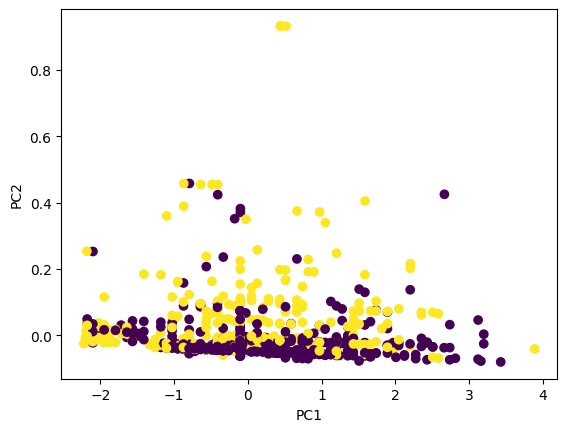

Logistic Regression accuracy (75/25 split): 0.7802690582959642


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# -------------------------------
# Step 0: Load Titanic dataset
# -------------------------------
URL = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(URL)

# -------------------------------
# Step 1: Impute missing values
# -------------------------------
df['Age'] = df['Age'].fillna(df['Age'].median())  # median
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])  # mode
df['Cabin'] = df['Cabin'].fillna('Unknown')  # fill with new category

# -------------------------------
# Step 2: Scale numeric features
# -------------------------------
# Standardize Age
scaler_age = StandardScaler()
df['Age_std'] = scaler_age.fit_transform(df[['Age']])

# Min-max scale Fare
scaler_fare = MinMaxScaler()
df['Fare_mm'] = scaler_fare.fit_transform(df[['Fare']])

# -------------------------------
# Step 3: Encode categorical features
# -------------------------------
ohe = OneHotEncoder(sparse_output=False, drop=None)

# Encode Sex
sex_ohe = ohe.fit_transform(df[['Sex']])
sex_cols = ohe.get_feature_names_out(['Sex'])
df_sex_ohe = pd.DataFrame(sex_ohe, columns=sex_cols)

# Encode Embarked
emb_ohe = ohe.fit_transform(df[['Embarked']])
emb_cols = ohe.get_feature_names_out(['Embarked'])
df_emb_ohe = pd.DataFrame(emb_ohe, columns=emb_cols)

# Concatenate encoded columns
df_processed = pd.concat([df, df_sex_ohe, df_emb_ohe], axis=1)

# -------------------------------
# Step 4: Transform Fare (log1p)
# -------------------------------
df_processed['Fare_log'] = np.log1p(df_processed['Fare'])

# -------------------------------
# Step 5 (Optional): PCA on numeric subset for 2D visualization
# -------------------------------
numeric_cols = ['Age_std', 'Fare_mm']
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_processed[numeric_cols])

# Optional: visualize PCA
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_processed['Survived'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# -------------------------------
# Step 6: Prepare dataset for logistic regression
# -------------------------------
features = ['Age_std', 'Fare_mm'] + list(sex_cols) + list(emb_cols)
X = df_processed[features]
y = df_processed['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression accuracy (75/25 split):", accuracy)

## ✅ What You Should Take Away from Part A

- Each step (imputation, scaling, encoding, transforms) has a **clear purpose** and **visible effect**.  
- You can now apply them **manually** and reason about their impact.  
- Next: move to **Part B (Pipelines)** to **combine & automate** these steps safely (avoid leakage, enable cross-validation, and reproducibility).